In [1]:
import re
import pandas as pd
#import rdfpandas as pd
import bs4
import requests
import spacy


from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy.pipeline import EntityRuler
from spacy.matcher import Matcher

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

import array as arr

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
candidate_sent = pd.read_csv("wikiwiki.csv", encoding = 'unicode_escape')
candidate_sent.shape

(18, 1)

In [3]:
nlp = spacy.load('es_core_news_md')

In [4]:
ruler= EntityRuler(nlp)
patterns= [{'label': 'ORG', 'pattern': 'Hoy duermo afuera'}]
ruler.add_patterns(patterns)
nlp.add_pipe(ruler)

In [5]:
matcher = Matcher(nlp.vocab)
nucleo = [{"DEP": "nsubj"}] #Caso 1 -"Los kayakistas contratan travesías en kayak." 
nucleoMD = [ {"DEP": "nsubj"}, {"DEP":"amod"}] #Caso 2 - "Los kayakistas expertos contratan travesías en kayak."
nucleoMI = [ {"DEP" : "nsubj"}, {"POS":"ADP"}, {"POS":"NOUN"}] #Caso 3.1 - "Los kayakistas de Córdoba contratan travesías en kayak." 
nucleoMIv1 = [ {"DEP" : "nsubj"}, {"POS":"ADP"}, {"POS":"DET"}, {"POS":"NOUN"}, {"POS":"ADJ"}]
nucleoMIv2 = [ {"DEP" : "nsubj"}, {"POS":"ADP"},  {"POS":"DET"}, {"POS":"NOUN"}] #Caso 3.2 - "Los kayakistas de la montaña contratan travesías en kayak." 
nucleoMIv3 = [ {"DEP" : "nsubj"}, {"POS":"ADP"},  {"DEP":"nmod"}] #Caso 3.3 - "Los kayakistas del pantano contratan travesías en kayak."
nucleoMDMI = [ {"DEP": "nsubj"}, {"DEP":"amod"}, {"POS":"ADP"}, {"POS":"NOUN"}] #Caso 4.1 - "Los kayakistas expertos de Córdoba contratan travesías en kayak."
nucleoMDMIv2 = [ {"DEP": "nsubj"}, {"DEP":"amod"}, {"POS":"ADP"},  {"POS":"DET"}, {"POS":"NOUN"}] #Caso 4.2 - "Los kayakistas expertos de la montaña contratan travesías en kayak."
nucleoMDMIv3 = [ {"DEP": "nsubj"}, {"DEP":"amod"},{"POS":"ADP"},  {"DEP":"nmod"}] #Caso 4.3 - "Los kayakistas expertos del pantano contratan travesías en kayak."


#estos dos hay que revisar, son temporales quizás
casoEspecial = [{"DEP" : "nsubj"}, {"POS":"ADP"}, {'DEP':'nummod'}, {"POS":"NOUN"} ]
casoEspecial2 = [{"DEP" : "nsubj"}, {"POS":"ADP"}, {'POS':'ADV'}, {"POS":"ADP"}, {'DEP':'nummod'}, {"POS":"NOUN"} ]

'''od = [{"POS": "VERB"}, {"DEP":"obj"}]
odv2 = [{"POS": "VERB"}, {"DEP":"obj"}, {"POS":"ADP"}, {"DEP":"nmod"}]

od_oi = [{"DEP":"obj"}, {"POS":"ADP"}, {"DEP":"obj"}, {"DEP":"amod"}]
od_oi_v2 = [{"DEP":"obj"}, {"POS":"ADP"}, {"DEP":"nmod"}, {"POS":"ADP"}, {"DEP":"obj"}]
od_oi_v3 = [{"DEP":"obj"}, {"POS":"ADP"}, {"DEP":"nmod"}, {"POS":"ADP"}, {"DEP":"obj"}, {"DEP":"amod"}]'''

matcher.add("Nucleo", None, nucleo)
matcher.add("NucleoMD", None, nucleoMD)
matcher.add("NucleoMI", None, nucleoMI)
matcher.add("NucleoMIv1", None, nucleoMIv1)
matcher.add("NucleoMIv2", None, nucleoMIv2)
matcher.add("NucleoMIv3", None, nucleoMIv3)
matcher.add("NucleoMDMI", None, nucleoMDMI)
matcher.add("NucleoMDMIv2", None, nucleoMDMIv2)
matcher.add("NucleoMDMIv3", None, nucleoMDMIv3)

matcher.add("casoEspecial", None, casoEspecial)
matcher.add("casoEspecial2", None, casoEspecial2)

'''matcher.add("OD", None, od)
matcher.add("ODv2", None, odv2)

matcher.add("OD_OI", None, od_oi)
matcher.add("OD_OI_v2", None, od_oi_v2)
matcher.add("OD_OI_v3", None, od_oi_v3)'''
    

'matcher.add("OD", None, od)\nmatcher.add("ODv2", None, odv2)\n\nmatcher.add("OD_OI", None, od_oi)\nmatcher.add("OD_OI_v2", None, od_oi_v2)\nmatcher.add("OD_OI_v3", None, od_oi_v3)'

In [6]:
def buscarPosicionVerbo(doc):
    posVerbo=-1
    for i in range(0, len(doc)):
        if (posVerbo == -1):
            if (doc[i].pos_ == "VERB" or doc[i].lemma_ == "ser"):
                posVerbo=i
    return posVerbo

In [7]:
#Procesar qué es "un costo" no resulta tarea sencilla. Por ahora definiré lo siguiente: todo lo que esté entre estos símbolos
# guiones representará "un costo", equivaldría a definirlo como entity pero eso requeriría cierto formato (inviable?).

def buscarUnCosto(doc):
    ent=""
    pos1=0
    pos2=0
    index=0
    for i in doc:
        if (i.text == "<"):
            pos1=index
        if (i.text == ">"):
            pos2=index
        index=index+1
    for i in range(pos1+1,pos2):
        ent=ent+doc[i].text+" "
    return [ent, pos2+1]


In [8]:
#Yo tengo que encontrar la forma de la oración. Si es VERBO + OD. O VERBO+OD+OI. Si supongo que tienen ese formato, entonces
#puedo preguntar si, lo que está "a continuación del verbo" es el OD. Y si lo que está "a continuación del OD" es el OI. ¿Manejarse con las posiciones?
#Es absolutamente necesario, PARA ESTA IMPLEMENTACIÓN que la oración termine con punto. Sino producirá error.

def buscarObjetos(doc):
    posVerbo= -1
    od=""
    oi=""
    ind=0
    posOD=0
    ret=[]
    
    #todo esto es para ver si hay una entidad costo, que sea el OD, y marco dónde terminaba el OD. Podría ser OI? Yo pienso que no, nunca responderá "a quien"
    ret= buscarUnCosto(doc)
    od=ret[0]
    posOD=ret[1]
    
    if (od==""):     
        posVerbo= buscarPosicionVerbo(doc)

        for i in range(posVerbo, len(doc)):        
            if (doc[i].dep_ == "obj" and (doc[i].pos_ == "NOUN" or doc[i].pos_ =="PROPN" or doc[i].pos_=="PRON" or doc[i].pos_=="ADJ" or doc[i].pos=="NUM" )) or doc[i].dep_== "obl" or (doc[i].dep_ == "ROOT" and (doc[i].pos_ =="NOUN" or doc[i].pos_=="ADJ" or doc[i].pos_ =="PROPN" )):  
                if (ind == 0): #el "ind" se está usando para marcar si había o no OD, si hay queda en 1
                    od=doc[i].text
                    if (doc[i+1].pos_ == "ADP"): #evalúa si el OD tenía al lado un modificador indirecto
                        if (doc[i+2].dep_ == "nmod"):
                            od= od+" "+doc[i+1].text+" "+doc[i+2].text
                            i=i+2
                    else:                       #o un modificador directo
                        if (doc[i+1].pos_ == "ADJ"):
                            od=od+" "+doc[i+1].text
                            i=i+1
                    ind=ind+1
                    posOD=i+1 
    
    if (doc[posOD].text !="."): #evita error. parche. lpm
        #Evaluará hallar un OI DESPUÉS del OD (para eso usa posOD)
        if (doc[posOD].pos_ == "ADP"): #El OI está encabezado por la preposición
            for i in range(posOD, len(doc)):
                if (doc[i].dep_ == "nummod" or doc[i].dep_ == "obj" or doc[i].dep_ == "nmod" or doc[i].dep_=="obl"):   
                    oi=doc[i].text
                    if (doc[i+1].pos_ == "ADP"): #evalúa si el OI tenía al lado un modificador indirecto
                        if (doc[i+2].dep_ == "nmod"):
                            oi= oi+" "+doc[i+1].text+" "+doc[i+2].text

                    else:                       #o un modificador directo
                        if (doc[i+1].pos_ == "ADJ" or doc[i+1].dep_=="nmod" or doc[i+1].dep_=="amod"):
                            oi=oi+" "+doc[i+1].text

    return [od, oi]


In [9]:
def get_ent(sent):
    ent=""
    for i in sent.ents:
        ent=ent+i.text
    return ent
        
def get_entities(sent):
    ent1 = ""
    ent2 = ""
    obj= []
    ent = ""
    
    sent=nlp(sent)
    ent=get_ent(sent) #Esto es reemplazable por un matcher 
    
    #Me fijo si encontré ent es porque descubrí una entidad, podría ser el núcleo? En realidad debería fijarse si es parte del sujeto esa entidad (si está antes del verbo?)
    #Hay un matcher para esto. No logré hacer que funcione, puse {"ENT_TYPE":"ORG"}
    if (ent!=""):
        ent1=ent
    else:
        #Mando a matchear con todos los patrones posibles. Devolverá el sujeto que sea correcto.
        matches = matcher(sent)
        for match_id, start, end in matches:
            string_id = nlp.vocab.strings[match_id]  # Get string representation
            span = sent[start:end]  # The matched span
        ent1=str(span)

    obj=buscarObjetos(sent)
    if (obj[1]!=""): #si tiene OI, la 2da ent es el OI porque la relacion va a ser el verbo+od
        ent2=obj[1]
    else:
        ent2=obj[0] #sino, la 2da ent es el od como siempre
            
    return [ent1.strip(), ent2.strip()]


In [10]:
#La relación está determinada meramente por los objetos directo e indirecto. Por lo tanto, se analiza lo siguiente:
# si tiene OI, la relación va a ser VERBO+OD
# si no tiene OI, la relación va a ser el VERBO
# Observar que se analiza "ser" como excepción
def get_relation(sent):
    doc = nlp(sent)
    rel=""
    
    for i in doc:
        if (i.lemma_ == "ser"):
            rel = i.text
            if (i.nbor().pos_ == "VERB"):    #sentencia para analizar formas verbales compuestas. ej: "es considerado", "fue medido"
                rel= i.text+" "+i.nbor().text   
        if (rel=="" and i.pos_ == "VERB"):  
            rel= i.text
    
    obj= buscarObjetos(doc)
    
    if (obj[1]!=""):
        #print("tiene oi")
        rel=rel+" "+obj[0]
    
    return(rel.strip())


In [11]:
entity_pairs = []

for sentence in candidate_sent['sentence']:
    entity_pairs.append(get_entities(sentence)) 
    
relations = [get_relation(i) for i in candidate_sent['sentence']] 

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

lemma = [nlp(i[0])[0].lemma_ for i in entity_pairs]

entity_pairs[0:30]

[['Hoy duermo afuera', 'empresa'],
 ['empresa', 'travesías en kayak'],
 ['kayakistas inexpertos', 'travesías en kayak'],
 ['kayakistas expertos', 'travesías en kayak'],
 ['empresa', 'kayakistas inexpertos'],
 ['empresa', 'kayakistas expertos'],
 ['travesías en kayak', 'duración'],
 ['travesías en kayak', 'itinerario'],
 ['travesías en kayak', 'costo'],
 ['duración', 'tiempo'],
 ['tiempo', 'días'],
 ['itinerario', 'secuencia de lugares'],
 ['kayakista', 'empresa'],
 ['empresa', 'kayakista'],
 ['travesías en kayak', 'kayakistas inexpertos'],
 ['costo adicional', 'costo'],
 ['travesías de 1 día', 'kayakistas expertos'],
 ['travesías de más de 1 día', 'kayakistas expertos']]

In [12]:
#esto es para saber si la relacion es verbo +od o verbo solo
def determinarRelacion(rel, ent2):   
    relacion=nlp(rel)      
    
    temp= ""
    
    tieneOI = False
    for i in relacion:
        if (i.dep_ == "obj" or i.dep_ == "nsubj"):
            tieneOI= True
            
        if (i.dep_ == "ROOT"):
            temp= temp+" "+str(i.lemma_).strip()
        else:
            temp=temp+" "+str(i).strip()
            
    if not tieneOI:
        rel= temp+ " "+ent2
    else:
        rel= temp
    return rel.strip()


In [13]:
class Clase():     
    def __init__(self):         
        self.nombre= ""         
        self.variablesInstancia= []         
        self.metodos= [] 
        self.subclases= []


def clase_existente(lista_clases, nombre_clase):
    for clase in lista_clases:
        if (nombre_clase == clase.nombre):
            return clase
    return None

def es_variable(relacion):
    rel=nlp(relacion)
    return (rel[0].lemma_ == "tener") and (len(rel) == 1)

def buscar_subclases(lemma, nombre_superclase):
    #Despues las subclases      
    subclases=[]
    for clase in lista_clases:
        if (not clase.nombre in dicLemma.values()):
            if (nlp(clase.nombre)[0].lemma_ == lemma):
                subclases.append(clase)
    return subclases

def es_subclase(buscada, lista_final):
    for clase in lista_final:
        if (buscada in clase.subclases):
            return True
    return False

#PROCESAMIENTO 1
#------------------------------------------------------------------------------------------------------------------
# A partir del df, hago una lista de posibles clases, con sus respectivos métodos y variables


lista_clases= []
#for index, row in df.iterrows():
#    existe= clase_existente(lista_clases, row['Entidad1'])
#    if (existe == None):
#        nueva= Clase()
#        nueva.nombre=row['Entidad1']
#        if (es_variable(row['relacion'])):
#            nueva.variablesInstancia.append(row['Entidad2'])
#        else:
#            rel= determinarRelacion(row['relacion'], row['Entidad2'])
#            nueva.metodos.append(rel)
#        lista_clases.append(nueva)
#    else:
#        if (es_variable(row['relacion'])):
#            existe.variablesInstancia.append(row['Entidad2'])
#        else:
#            rel= determinarRelacion(row['relacion'], row['Entidad2'])
#            existe.metodos.append(rel)
for i in range(0,len(source)):
    existe= clase_existente(lista_clases, source[i])
    if (existe == None):
        nueva= Clase()
        nueva.nombre=source[i]
        if (es_variable(relations[i])):
            nueva.variablesInstancia.append(target[i])
        else:
            rel= determinarRelacion(relations[i], target[i])
            nueva.metodos.append(rel)
        lista_clases.append(nueva)
    else:
        if (es_variable(relations[i])):
            existe.variablesInstancia.append(target[i])
        else:
            rel= determinarRelacion(relations[i], target[i])
            existe.metodos.append(rel)


#PROCESAMIENTO 2
# ---------------------------------------------------------------------------------------------------------------------------
#Establezco jerarquias.. Por cada una de las enntidades, voy a mirar si el ENTIDAD=LEMA. 
# Una vez que encuentro ENTIDAD=LEMA, voy a recorrer la lista buscando todas las jerarquias y reacomodando los ptros

dicLemma = dict()
for clase in lista_clases:
    dicLemma[clase.nombre]=nlp(clase.nombre)[0].lemma_
    
lista_final = [] #Mi idea inicial era usar el método remove pero rompí todo. Abierto absolutamente a quien quiera intentarlo. Tiene que remover las "subclases" que encuentra de la lista_clases, luego de hacer que la clase las agregue como sus subclases

for clase in lista_clases:
    if (dicLemma[clase.nombre] == clase.nombre):     #procesara las de mismo lema y nombre        
        clase.subclases= buscar_subclases(dicLemma[clase.nombre], clase.nombre)
        if (len(clase.subclases)>0):
            lista_final.append(clase)

#Una vez que establecí jerarquías, proceso todo lo que no sea jerarquía (ni clase, ni subclase de esa clase)            
for clase in lista_clases:
    if (not es_subclase(clase, lista_final) and not clase in lista_final):
        cantidad_variables= len(clase.variablesInstancia)
        cantidad_metodos= len(clase.metodos)
        if ((cantidad_variables+cantidad_metodos)>1):
            lista_final.append(clase)

#Set con todos los métodos para eliminar repeticiones
for clase in lista_final:
    for subclase in clase.subclases:
        subclase.metodos= set(subclase.metodos)
    clase.metodos= set(clase.metodos)
        
                 

CLASE: kayakista
 - Variables de instancia: 
  - Metodos: solicitar cotización, 
 SUBCLASE: kayakistas inexpertos
 - Variables de instancia: 
  - Metodos: contratar travesías en kayak, 
 SUBCLASE: kayakistas expertos
 - Variables de instancia: 
  - Metodos: contratar travesías en kayak, 

-----------------------------------------------------------------------------
CLASE: empresa
 - Variables de instancia: 
  - Metodos: informar arancel, ofrecer travesías en kayak, 

-----------------------------------------------------------------------------
CLASE: travesías en kayak
 - Variables de instancia: duración, itinerario, costo, 
  - Metodos: tener costo adicional, 

-----------------------------------------------------------------------------
                        Entidad1                            relacion  \
0              Hoy duermo afuera                                  es   
1                        empresa                              ofrece   
2          kayakistas inexpertos   

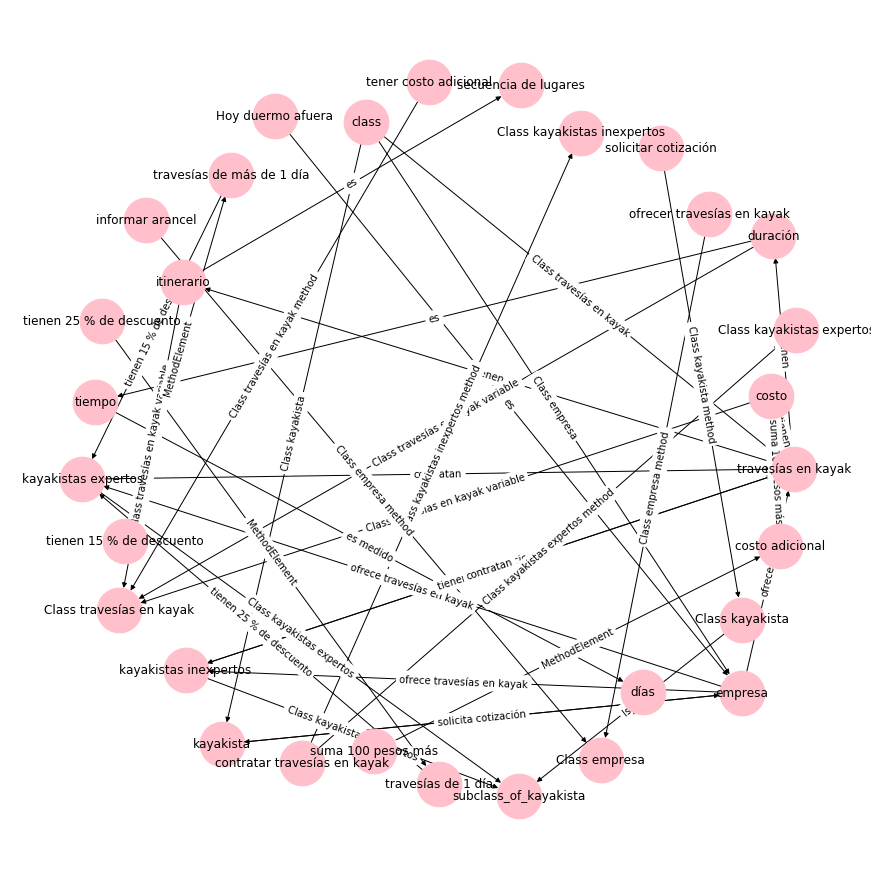

In [14]:
data=[]
dataSource=[]
for i in relations:
    doc=nlp(i)
    for k in doc:
        if k.pos_=='NUM':
            data.append(i)
            index = relations.index(i)
            dataSource.append(source[index])
#for clase in lista_final:
#    print('CLASE:',clase.nombre)
#    source.append(clase.nombre)
#    target.append('Class')
#    relations.append('Is_a')
#    print(' - Variables de instancia: ', end= "")
#    for variable in clase.variablesInstancia:
#        print(variable, end=", ")
#        source.append(variable)
#        target.append('instance_var_'+clase.nombre)
#        relations.append('Is_a')
#    print()
#    print('  - Metodos: ', end="")
#    for metodo in clase.metodos:
#        print(metodo, end= ", ")
#        source.append(metodo)
#        target.append('method_of_'+clase.nombre)
#        relations.append('Is_a')
#    print()
        
    
#    for subclase in clase.subclases:
#        print(' SUBCLASE:', subclase.nombre)
#        source.append(subclase.nombre)
#        target.append('subclass_of_'+clase.nombre)
#        relations.append('Is_a')
#        print(' - Variables de instancia: ', end="")
#        for variable in subclase.variablesInstancia:
#            print(variable, end=", ")
#            source.append(variable)
#            target.append('instance_var_'+subclase.nombre)
#            relations.append('Is_a')
#        print()
#        print('  - Metodos: ', end="")
#        for metodo in subclase.metodos:
#            print(metodo, end= ", ")
#            source.append(metodo)
#            target.append('method_of_'+subclase.nombre)
#            relations.append('Is_a')
#        print()
#    print()
#    print('-----------------------------------------------------------------------------')
for clase in lista_final:
    print('CLASE:',clase.nombre)
    source.append('class') #nodo principal
    target.append(clase.nombre)
    relations.append('Class '+clase.nombre)#intento de identificador
    print(' - Variables de instancia: ', end= "")
    for variable in clase.variablesInstancia:
        print(variable, end=", ")
        source.append(variable)
        target.append('Class '+clase.nombre)
        relations.append('Class '+clase.nombre+' variable')
    print()
    print('  - Metodos: ', end="")
    for metodo in clase.metodos:
        print(metodo, end= ", ")
        source.append(metodo)
        target.append('Class '+clase.nombre)
        relations.append('Class '+clase.nombre+' method')
    print()
        
    
    for subclase in clase.subclases:
        source.append('Class '+clase.nombre)
        target.append('subclass_of_'+clase.nombre)
        relations.append('Is_a')
        print(' SUBCLASE:', subclase.nombre)
        source.append(subclase.nombre)
        target.append('subclass_of_'+clase.nombre)
        relations.append('Class '+subclase.nombre)
        print(' - Variables de instancia: ', end="")
        for variable in subclase.variablesInstancia:
            print(variable, end=", ")
            source.append(variable)
            target.append('Class '+subclase.nombre)
            relations.append('Class '+subclase.nombre+' variable')
        print()
        print('  - Metodos: ', end="")
        for metodo in subclase.metodos:
            print(metodo, end= ", ")
            source.append(metodo)
            target.append('Class '+subclase.nombre)
            relations.append('Class '+subclase.nombre+' method')
        print()
    print()
    print('-----------------------------------------------------------------------------')
for i in data:
    source.append(i)
    relations.append('MethodElement')
    target.append(dataSource[data.index(i)])
# class---> entity 1: ej:travesias relation: es una entity 2: clase
# subclass---> entity 2: kayakista inexperto relation: es una entity2:subclass_kayakista
# methods---> entity 1:solicitar_cotizacion() relation : es un entity:2 method_travesia
# instance_var----> entity1:duracion relation:es una entity2: instance_var_travesias_en_kayak
#-------------------------------------template-----------------------------------------------
# class------> entity1: ENT1 relation: Es una      ENT2: clase
# subclass --------> entity1: EN1 relation: Es una ENT2: subclase_ENT2
# methods ---------> ENT1: EN1 relation: Es un ENT:metodo_ENT2
# instance_var --------> Ent1:EN1 relation: Es una ENT2: variable_de_instancia_ENT2
#--------------------------------------------------------------------------------------------
# methodbody, methodElement to do list
# entity1: 100 pesos relation: methodElement entity2: costo
df = pd.DataFrame({'Entidad1': source, 'relacion': relations, 'Entidad2': target})
print(df)
plt.figure(figsize=(12,12))
G = nx.from_pandas_edgelist(df=df, source='Entidad1', target='Entidad2', edge_attr='relacion',
                           create_using=nx.DiGraph())
pos = nx.spring_layout(G, k=5)  # nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw(G, pos, with_labels=True, node_color='pink', node_size=2000)
labels = {e: G.edges[e]['relacion'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_cmap=plt.cm.Blues, edge_labels=labels)
plt.show()

                        Entidad1                            relacion  \
0              Hoy duermo afuera                                  es   
1                        empresa                              ofrece   
2          kayakistas inexpertos                           contratan   
3            kayakistas expertos                           contratan   
4                        empresa           ofrece travesías en kayak   
5                        empresa           ofrece travesías en kayak   
6             travesías en kayak                              tienen   
7             travesías en kayak                              tienen   
8             travesías en kayak                              tienen   
9                       duración                                  es   
10                        tiempo                           es medido   
11                    itinerario                                  es   
12                     kayakista                 solicita cotiza

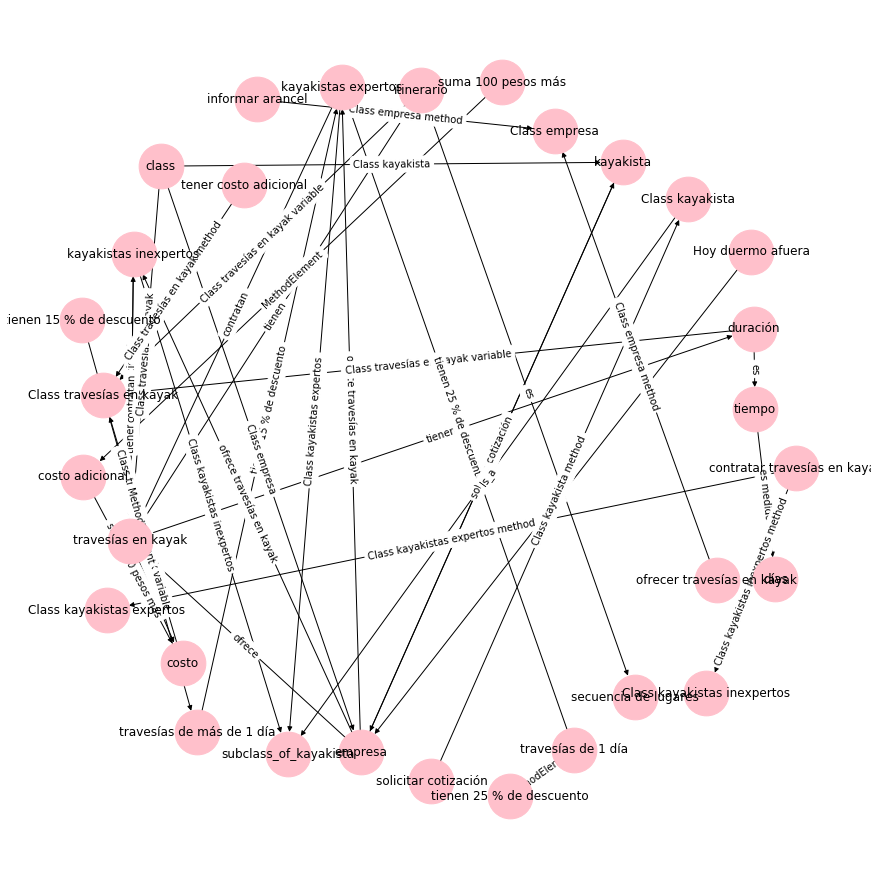

In [31]:
df = pd.DataFrame({'Entidad1': source, 'relacion': relations, 'Entidad2': target})
print(df)
plt.figure(figsize=(12,12))
G = nx.from_pandas_edgelist(df=df, source='Entidad1', target='Entidad2', edge_attr='relacion',
                           create_using=nx.DiGraph())
pos = nx.spring_layout(G, k=5)  # nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw(G, pos, with_labels=True, node_color='pink', node_size=2000)
labels = {e: G.edges[e]['relacion'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_cmap=plt.cm.Blues, edge_labels=labels)
plt.show()
#source relation target
#matcher:{VERB: dic[0]} contratar kayakistas
#source relation target
#empresa asociation kayakista

In [16]:
import os
file = open("Test.txt", "w")
##print("\"")

In [17]:
file.write("@startuml" + os.linesep) # inicio del archivo :D kk
for clase in lista_final:
    file.write("class \""+clase.nombre+ "\" {" + os.linesep)
    for variable in clase.variablesInstancia:
        file.write("Variable de instancia : "+ variable + os.linesep)
    for metodo in clase.metodos:
        kk=""
        doc = nlp(metodo)
        for i in doc:
            kk=kk+i.text+"_"
        file.write(kk+"()" + os.linesep)
    file.write("}" + os.linesep)  #cierro clase  
    for subclase in clase.subclases:
        kk=""
        doc=nlp(subclase.nombre)
        for i in doc:
            kk=kk+i.text+"_"
        file.write("\""+clase.nombre+"\" <|-- "+"\""+subclase.nombre+"\""+ os.linesep)
        file.write("class \""+subclase.nombre+"\" {" + os.linesep)
        for variable in subclase.variablesInstancia:
            file.write("Variable de instancia : "+ variable + os.linesep)
        for metodo in subclase.metodos:
            kk=""
            doc = nlp(metodo)
            for i in doc:
                kk=kk+i.text+"_"
            file.write(kk+"()"+ os.linesep)
        file.write("}" + os.linesep)
file.write("@enduml" + os.linesep)
file.close()


In [18]:
os.system("java -jar plantuml.jar test.txt")

0

In [19]:
import rdflib #testing RDF
from rdflib import Graph, RDF, Literal, Namespace, FOAF
#(subject0, predicate0, object0)
#(entidad1,relacion,entidad2) para nosotros
# create a Graph
gf = Graph()
EX = Namespace("http://example.org/")
#print(len(source))
for i in range(0,len(source)):
    #print((source[i],relations[i],target[i]))
    kk=""
    kk=source[i].replace(" ", "_")
    #doc = source[i].split()
    #for j in doc:
    #    kk=kk+j+"_"
    gg=""
    gg=target[i].replace(" ", "_")
    #doc = target[i].split()
    #for j in doc:
    #    gg=gg+j+"_"
    zz=""
    zz=relations[i].replace(" ", "_")
    #doc = relations[i].split()
    #for j in doc:
    #    zz=zz+j+"_"
    gf.add((EX[kk],EX[zz],EX[gg]))
    #g.add(Literal(relations[i]))
    #g.add(Literal(target[i]))
#RDF.type
bob = EX['bob']
alice = EX['alice']
#gf.add((bob,RDF.type,FOAF.Person))
#gf.add((bob,RDF.type,alice))
print(gf.serialize(format='n3', indent=4).decode("utf-8"))
gf.serialize(destination='output.txt', format='n3')

@prefix ns1: <http://example.org/> .
@prefix ns2: <http://example.org/tienen_15_%> .
@prefix ns3: <http://example.org/tienen_25_%> .

ns1:Hoy_duermo_afuera ns1:es ns1:empresa .

ns1:class ns1:Class_empresa ns1:empresa ;
    ns1:Class_kayakista ns1:kayakista ;
    ns1:Class_travesías_en_kayak ns1:travesías_en_kayak .

ns1:contratar_travesías_en_kayak ns1:Class_kayakistas_expertos_method ns1:Class_kayakistas_expertos ;
    ns1:Class_kayakistas_inexpertos_method ns1:Class_kayakistas_inexpertos .

ns1:informar_arancel ns1:Class_empresa_method ns1:Class_empresa .

ns1:ofrecer_travesías_en_kayak ns1:Class_empresa_method ns1:Class_empresa .

ns1:solicitar_cotización ns1:Class_kayakista_method ns1:Class_kayakista .

ns1:suma_100_pesos_más ns1:MethodElement ns1:costo_adicional .

ns1:tener_costo_adicional ns1:Class_travesías_en_kayak_method ns1:Class_travesías_en_kayak .

ns2:_de_descuento ns1:MethodElement ns1:travesías_de_más_de_1_día .

ns3:_de_descuento ns1:MethodElement ns1:travesías_de_1_

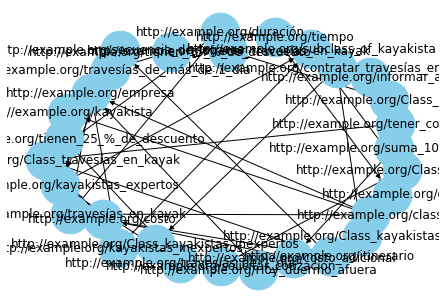

In [20]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
G = rdflib_to_networkx_multidigraph(gf)

# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=1900)
edge_labels = nx.get_edge_attributes(G, 'r')
#nx.draw_networkx_edge_labels(G, pos, labels=edge_labels)
#nx.draw(G, with_labels=True)
pos = nx.spring_layout(G, k=5)  # nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [21]:
print (data)
print('---')
print(dataSource)

['suma 100 pesos más', 'tienen 25 % de descuento', 'tienen 15 % de descuento']
---
['costo adicional', 'travesías de 1 día', 'travesías de más de 1 día']


In [22]:
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  ?a ?title
WHERE   { ?a dc:Is_a ?title }  """)
for row in qres:
    print(row)
#z932 ska
#funka pregunto por las relaciones Is_a

(rdflib.term.URIRef('http://example.org/Class_kayakista'), rdflib.term.URIRef('http://example.org/subclass_of_kayakista'))


In [23]:
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  ?title
WHERE   { ?a dc:MethodElement ?title }  """)
for row in qres:
    print(row)

(rdflib.term.URIRef('http://example.org/travesías_de_más_de_1_día'),)
(rdflib.term.URIRef('http://example.org/travesías_de_1_día'),)
(rdflib.term.URIRef('http://example.org/costo_adicional'),)


In [24]:
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  ?title
WHERE   { ?a dc:tienen ?title }  """)
for row in qres:
    print(row)

(rdflib.term.URIRef('http://example.org/costo'),)
(rdflib.term.URIRef('http://example.org/duración'),)
(rdflib.term.URIRef('http://example.org/itinerario'),)


In [25]:
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  ?title
WHERE   { ?a dc:es ?title }  """)
for row in qres:
    print(row)

(rdflib.term.URIRef('http://example.org/secuencia_de_lugares'),)
(rdflib.term.URIRef('http://example.org/empresa'),)
(rdflib.term.URIRef('http://example.org/tiempo'),)


In [26]:
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  ?title
WHERE   { ?a dc:contratan ?title }  """)
for row in qres:
    print(row)

(rdflib.term.URIRef('http://example.org/travesías_en_kayak'),)
(rdflib.term.URIRef('http://example.org/travesías_en_kayak'),)


In [27]:
#para hacer un query y sacar por relacion es siempre ?variable dc:la_relacion_ ?otraVariable
# en este caso tenemos a anterior a la relacion y title posterior a la relacion
#a ->relacion ->title
#WHERE{?Entidad1 dc:relacion ?Entidad2}
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  $a
WHERE   { ?a dc:contratan ?b }  """)
for row in qres:
    print(row)

(rdflib.term.URIRef('http://example.org/kayakistas_inexpertos'),)
(rdflib.term.URIRef('http://example.org/kayakistas_expertos'),)


In [28]:
#saco las clases
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  $s 
WHERE   { ?s dc:Class_travesías_en_kayak_variable ?c }  """)
for row in qres:
    print(row)

(rdflib.term.URIRef('http://example.org/itinerario'),)
(rdflib.term.URIRef('http://example.org/duración'),)
(rdflib.term.URIRef('http://example.org/costo'),)


In [29]:
cosas='Class_'
print("inserte el nombre de la clase")
clase=input()
cosas=cosas+clase+'_'
print("elija una de las opciones: 1)variablesDeInstancia 2)Metodos ")
c=input()
if c=='1':
    cosas=cosas+'variable'
elif c=='2':
    cosas=cosas+'method'
print(cosas)

inserte el nombre de la clase


 empresa


elija una de las opciones: 1)variablesDeInstancia 2)Metodos 


 2


Class_empresa_method


In [32]:
#saco las clases
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  $s 
WHERE   { ?s dc:Class_empresa_method ?c}  """)
for row in qres:
    print(row)

(rdflib.term.URIRef('http://example.org/informar_arancel'),)
(rdflib.term.URIRef('http://example.org/ofrecer_travesías_en_kayak'),)


In [36]:
#a="""PREFIX  dc: <http://example.org/>
#SELECT  $s
#WHERE   { ?s dc:"""+cosas+""" ?c}  """
qres = gf.query(
   """PREFIX  dc: <http://example.org/>
SELECT  $s 
WHERE   { ?s """+'dc:'+cosas+""" ?c}  """)